In [1]:
!pip install openai

from openai import OpenAI
from google.colab import userdata
import base64
import requests
import json
import ast

client = OpenAI(
    # This is the default and can be omitted
    api_key=userdata.get('OPENAI_API_KEY'),
)

In [2]:
!pip install --upgrade diffusers

import torch
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(
    "jiuntian/gligen-xl-1024", trust_remote_code=True, torch_dtype=torch.float16
).to("cuda")

model_index.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

pipeline_gligen_sdxl.py:   0%|          | 0.00/70.6k [00:00<?, ?B/s]

Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/751 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

(…)pytorch_model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

(…)pytorch_model-00002-of-00002.safetensors:   0%|          | 0.00/7.52G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/355k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

Keyword arguments {'trust_remote_code': True} are not expected by StableDiffusionXLGLIGENPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
import torch
import math
import numpy as np
from PIL import Image, ImageDraw, ImageFont

def get_rect(bbox):
  elements = bbox.split('[')
  object_name = elements[0].strip()
  coordinates = elements[1].split(']')[0].split(', ')
  bbox_coor = []
  for i in coordinates:
    bbox_coor.append(eval(i))

  bbox_coor = torch.Tensor(bbox_coor)

  x, y, w, h = bbox_coor[0], bbox_coor[1], bbox_coor[2], bbox_coor[3]
  rect = [float(x), float(y), float(w), float(h)]
  return object_name, rect

def draw_layout(bboxes_list, path):

  w = 512
  h = 512

  fnt = ImageFont.truetype("/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf", 12)

  img = Image.new("RGB", (w, h), 'white')
  img1 = ImageDraw.Draw(img)

  bboxes = []
  for el in bboxes_list:
    start = '['
    end = ']'
    s = el
    obj = (s.split(start))[0].strip()
    coor = (s.split(start))[1].split(end)[0]
    coor_list = coor.split(', ')
    temp_bboxes = []
    for i in coor_list:
      temp_bboxes.append(round(eval(i) * 512, 3))

    el = obj + str(temp_bboxes)
    bboxes.append(el)

  color = "black"
  for el in bboxes:
    obj_name, obj_rect = get_rect(el)
    img1.rectangle(obj_rect, outline = color)
    img1.text((obj_rect[0], obj_rect[1]), obj_name, color, font=fnt)

  layout_path = path
  img.save(layout_path)
  return layout_path

def blank_layout(path):
  w = 512
  h = 512

  img = Image.new("RGB", (w, h), 'white')
  layout_path = path
  img.save(layout_path)
  return layout_path


In [22]:
with open("/content/MLLM-Guidance/LLM-prompts/grounding_prompt.txt", "r") as my_file:
  generator_prompt = my_file.read()

with open("/content/MLLM-Guidance/LLM-prompts/self-correcting_prompt.txt", "r") as my_file:
  adjuster_prompt = my_file.read()

with open("/content/MLLM-Guidance/LLM-prompts/reasoning_prompt.txt", "r") as my_file:
  evaluator_prompt = my_file.read()

with open("/content/MLLM-Guidance/LLM-prompts/aligning_prompt.txt", "r") as my_file:
  aligner_prompt = my_file.read()

In [23]:
def generate_layout(caption, sys_prompt=generator_prompt):
  prompt = sys_prompt + caption
  start = 'Objects: '
  gpt_exp = ''
  while (gpt_exp == None) or (start not in gpt_exp):
    response_1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[
          {
            "role": "user",
            "content": [
              {"type": "text", "text": prompt},
            ],
          }
        ],
        max_tokens=300,
      )

    gpt_exp = response_1.choices[0].message.content
    #print(gpt_exp)

  s = gpt_exp
  coordinates = s.split(start)[1].strip()

  if coordinates.endswith(']\']') or coordinates.endswith(']]') or coordinates.endswith('\n]'):
    coordinates = ast.literal_eval(coordinates)

  return coordinates

In [24]:
def adjust_layout(caption, bboxes, sys_prompt=adjuster_prompt):
  post_prompt = 'User prompt: ' + caption + '\nCurrent Objects: ' + str(bboxes)
  prompt = sys_prompt + post_prompt
  start = 'Updated Objects: '
  gpt_exp = ''
  while (gpt_exp == None) or (start not in gpt_exp):
    response_2 = client.chat.completions.create(
        model="gpt-4o",
        messages=[
          {
            "role": "user",
            "content": [
              {"type": "text", "text": prompt},
            ],
          }
        ],
        max_tokens=300,
      )

    gpt_exp = response_2.choices[0].message.content
    #print(gpt_exp)

  s = gpt_exp
  updated_coordinates = s.split(start)[1].strip()

  if updated_coordinates.endswith(']\']') or updated_coordinates.endswith(']]') or updated_coordinates.endswith('\n]'):
    updated_coordinates = ast.literal_eval(updated_coordinates)

  return updated_coordinates

In [25]:
def evaluate_image(caption, image_path, sys_prompt=evaluator_prompt):
  # Function to encode the image
  def encode_image(image_path):
    with open(image_path, "rb") as image_file:
      return base64.b64encode(image_file.read()).decode('utf-8')

  # Getting the base64 string
  base64_image = encode_image(image_path)
  prompt = sys_prompt + caption
  start = 'Score: '
  gpt_exp = ''
  while (gpt_exp == None) or (start not in gpt_exp):
    response_1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[
          {
            "role": "user",
            "content": [
              {"type": "text", "text": prompt},
              {
              "type": "image_url",
              "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
              },
            ],
          }
        ],
        max_tokens=300,
      )

    gpt_exp = response_1.choices[0].message.content
    print(gpt_exp)

  s = gpt_exp
  score = s.split(start)[1].strip()

  return int(score)

In [26]:
def align_image(caption, image_path, sys_prompt=aligner_prompt):
  # Function to encode the image
  def encode_image(image_path):
    with open(image_path, "rb") as image_file:
      return base64.b64encode(image_file.read()).decode('utf-8')

  # Getting the base64 string
  base64_image = encode_image(image_path)

  post_prompt = 'User prompt: ' + caption
  prompt = sys_prompt + post_prompt
  start = 'Updated Objects: '
  gpt_exp = ''
  while (gpt_exp == None) or (start not in gpt_exp):
    response_3 = client.chat.completions.create(
        model="gpt-4o",
        messages=[
          {
            "role": "user",
            "content": [
              {"type": "text", "text": prompt},
              {
              "type": "image_url",
              "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
              },
            ],
          }
        ],
        max_tokens=300,
      )

    gpt_exp = response_3.choices[0].message.content
    #print(gpt_exp)

  s = gpt_exp
  updated_coordinates = s.split(start)[1].strip()

  if updated_coordinates.endswith(']\']') or updated_coordinates.endswith(']]') or updated_coordinates.endswith('\n]'):
    updated_coordinates = ast.literal_eval(updated_coordinates)

  return updated_coordinates

In [27]:
def generate_gligen_image(caption, bboxes, latents, pipe=pipeline):
  gligen_boxes = []
  gligen_phrases = []
  for el in bboxes:
    if el[0] == '[':
      el = ast.literal_eval(el)[0]
    start = '['
    end = ']'
    s = el
    gligen_phrases.append((s.split(start))[0].strip())
    coor = (s.split(start))[1].split(end)[0]
    coor_list = coor.split(', ')
    temp_bboxes = []
    for i in coor_list:
      temp_bboxes.append(eval(i))
    gligen_boxes.append(temp_bboxes)

  image = pipe(
    prompt,
    num_inference_steps=50,
    height=1024, width=1024,
    gligen_scheduled_sampling_beta=0.4,
    gligen_boxes=gligen_boxes,
    gligen_phrases=gligen_phrases,
    num_images_per_prompt=1,
  ).images[0]

  return image

In [28]:
def generate_latents(seed, pipe = pipeline):
  #set manual latents
  device = "cuda"
  generator = torch.Generator(device=device)

  latents = None
  height, width = 1024, 1024
  generator = generator.manual_seed(seed)
  image_latents = torch.randn(
          (1, pipe.unet.in_channels, height // 8, width // 8),
          generator = generator,
          device = device
      )
  latents = image_latents if latents is None else torch.cat((latents, image_latents))
  return latents

In [29]:
def generate_grounded(caption, latents):
  #print("Grounded layout:")
  bboxes = generate_layout(caption)
  grounded_layout_path = draw_layout(bboxes, "grounded_layout.jpg")
  image = generate_gligen_image(caption, bboxes, latents)
  grounded_image_path = "grounded_image.jpg"
  image.save(grounded_image_path)
  return bboxes

In [30]:
def generate_adjusted(caption, latents, bboxes, cycle):
  #print("Adjusted layout:")
  existing_bboxes = bboxes
  i=0
  while i < cycle:
    adjusted_bboxes = adjust_layout(caption, existing_bboxes)
    if adjusted_bboxes == existing_bboxes:
      break
    existing_bboxes = adjusted_bboxes
    i=i+1
  adjusted_layout_path = draw_layout(adjusted_bboxes, "adjusted_layout.jpg")
  image = generate_gligen_image(caption, adjusted_bboxes, latents)
  adjusted_image_path = "adjusted_image.jpg"
  image.save(adjusted_image_path)
  return adjusted_image_path

In [31]:
def generate_aligned(caption, latents, image_path, cycle):
  if 'grounded' in image_path:
    image_name = "aligned_grounded_image.jpg"
  elif 'adjusted' in image_path:
    image_name = "aligned_adjusted_image.jpg"
    layout_name = "aligned_adjusted_layout.jpg"
  else:
    image_name = "aligned_image.jpg"

  existing_image_path = image_path
  existing_score = 0

  i=0
  while existing_score != 5 and i < cycle:
    aligned_bboxes = align_image(caption, existing_image_path)
    if aligned_bboxes in ['','[]',' ', '[ ]']:
      image = Image.open(existing_image_path)
      image_path = image_name
      image.save(image_path)
      break
    image = generate_gligen_image(caption, aligned_bboxes, latents)
    temp_image_path = "temp_image.jpg"
    image.save(temp_image_path)
    score = evaluate_image(caption, temp_image_path)

    if score >= existing_score:
      aligned_adjusted_layout_path = draw_layout(aligned_bboxes, layout_name)
      image_path = image_name
      image.save(image_path)
      existing_score = score
      existing_image_path = image_path

    i=i+1
  return image_name

In [32]:
def text_to_image(seed, caption, cycle):
  latents = generate_latents(seed, pipe = pipeline)

  # Base image
  # generate_base(caption, latents)

  # Grounded image
  bboxes = generate_grounded(caption, latents)

  # Adjusting grounding information
  adjusted_image_path = generate_adjusted(caption, latents, bboxes, cycle)

  # Aligning grounded image
  #grounded_image_path = "grounded_image.jpg"
  #grounded_layout_path = "grounded_layout.jpg"
  #aligned_grounded_bboxes = generate_aligned(caption, latents, grounded_image_path, cycle)

  # Aligning adjusted image
  aligned_adjusted_image_path = generate_aligned(caption, latents, adjusted_image_path, cycle)

  return aligned_adjusted_image_path


In [33]:
def bench_evaluate(caption, image_path):
  # Function to encode the image
  def encode_image(image_path):
    with open(image_path, "rb") as image_file:
      return base64.b64encode(image_file.read()).decode('utf-8')

  # Getting the base64 string
  base64_image = encode_image(image_path)

  response_1 = client.chat.completions.create(
    model="gpt-4o",
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text", "text": "You are my assistant to evaluate the correspondence of the image to a given text prompt. Briefly describe the image within 50 words, focus on the objects in the image and their attributes (such as color, shape, texture), spatial layout and action relationships."},
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          },
        ],
      }
    ],
    max_tokens=300,
  )

  gpt_exp = response_1.choices[0].message.content

  input_text = "According to the image and your previous answer, evaluate how well the image aligns with the text prompt: " + caption + ". Give a score from 0 to 100, according to the criteria: \n 100: the image is quite realistic and perfectly matches the content of the text prompt, with no discrepancies. \n 75: the image is realistic and contains all objects but the relationships and actions are not complete. \n 50: the image contains all objects but may be not realistic. \n 25: the image contains the main object but not other objects that should be there. \n 0: the image contains no objects given in the text prompt. Provide your analysis and explanation in JSON format with the following keys: score (e.g., 85), explanation (within 20 words)."
  response_2 = client.chat.completions.create(
    model="gpt-4o",
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text", "text": input_text},
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          },
        ],
      }
    ],
    max_tokens=300,
  )

  response_json = response_2.choices[0].message.content
  start = '\"score\":'
  end = ','
  s = response_json
  score = s.split(start)[1].split(end)[0].strip()

  return int(score)

--- A man is holding a briefcase and rushing to catch a train. --- 


<ipython-input-28-c1a395a35c51>:10: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

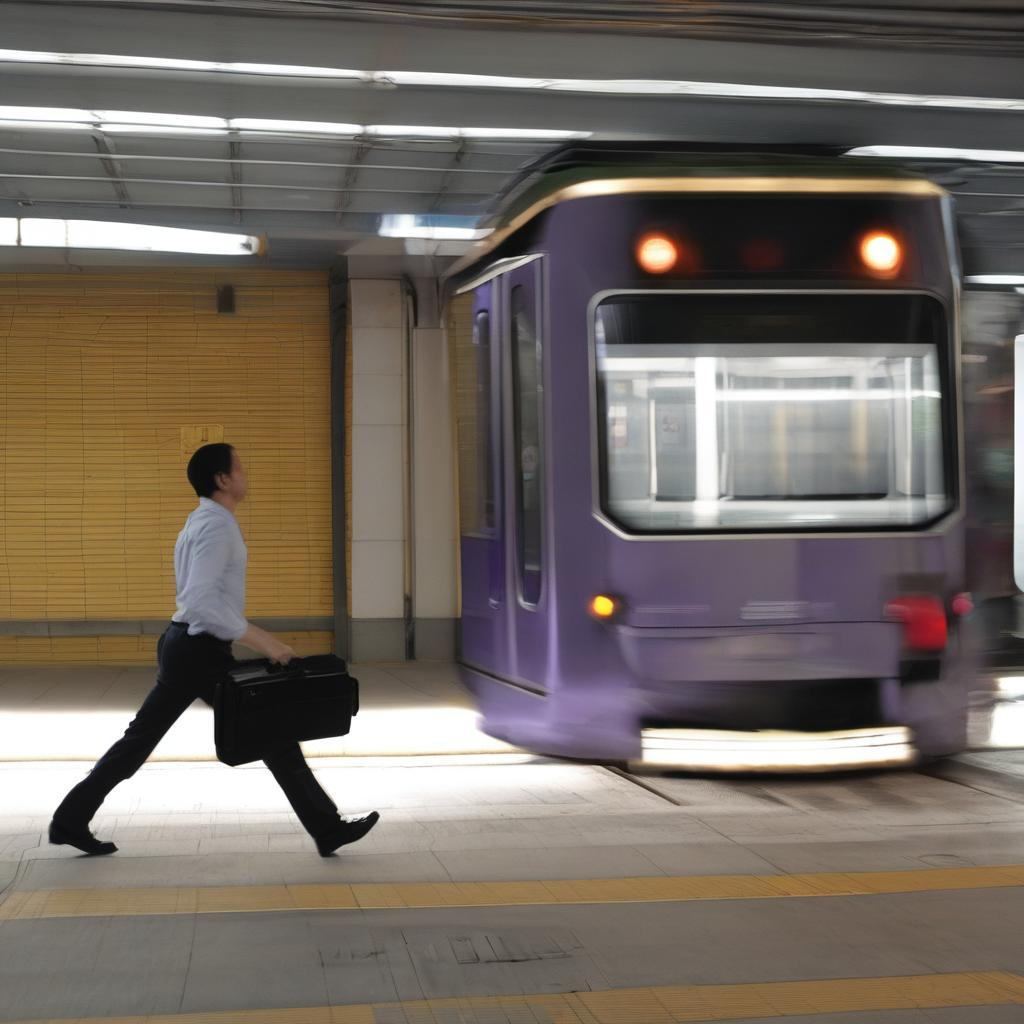

In [34]:
prompt = "A man is holding a briefcase and rushing to catch a train."
print("--- "+prompt+" --- ")
image_path = text_to_image(8888, prompt, 5)
image = Image.open(image_path)
image

--- A woman is holding a shopping bag and admiring a new dress. --- 


<ipython-input-28-c1a395a35c51>:10: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Reasoning: The image shows a woman holding a shopping bag, but she is not visibly admiring a new dress.

Score: 3


  0%|          | 0/50 [00:00<?, ?it/s]

Reasoning: The image shows shopping bags and a dress but lacks a woman admiring it.
Score: 2


  0%|          | 0/50 [00:00<?, ?it/s]

Reasoning: The woman is holding a bag and admiring a dress, clearly depicting the prompt's elements and actions.

Score: 5


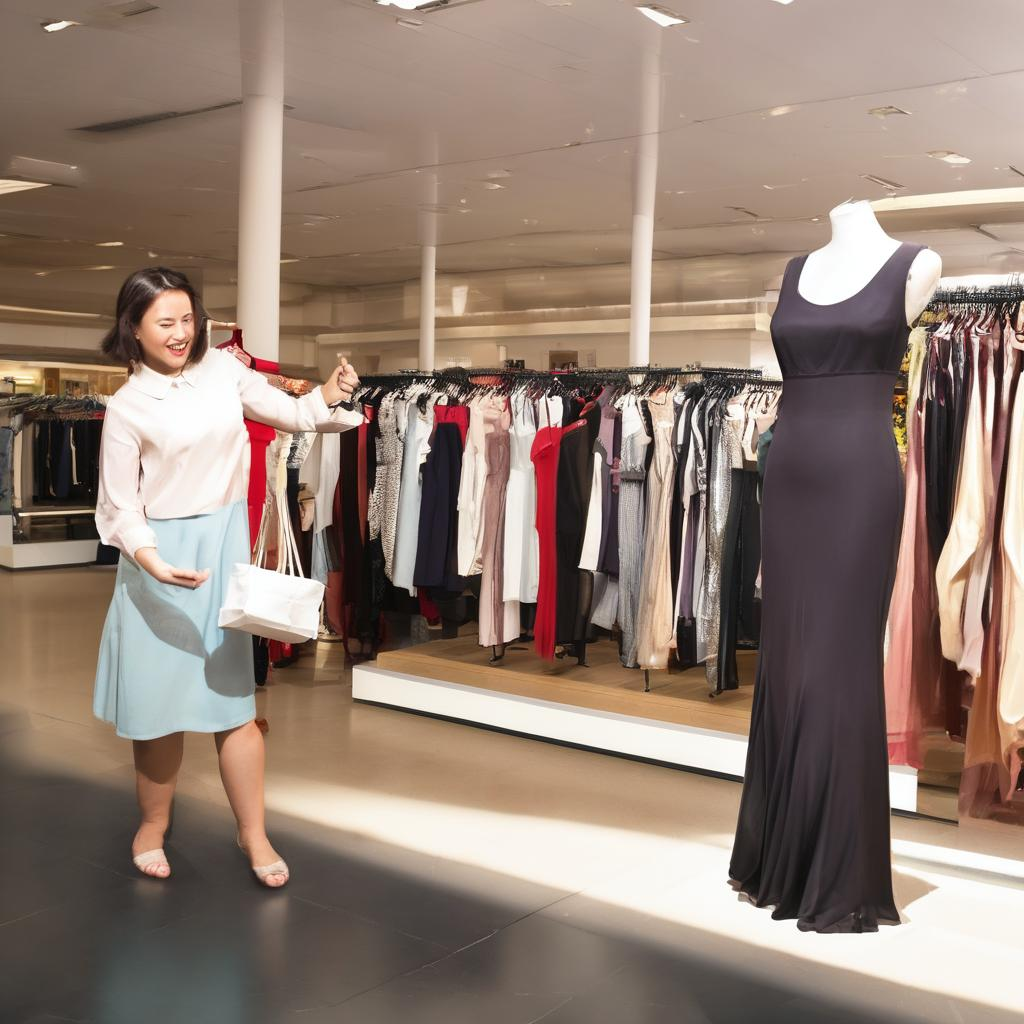

In [35]:
task="RLS-300"
file_name = "/content/MLLM-Guidance/benchmarks/" + task + "_val.txt"
my_file = open(file_name, "r")

data = my_file.read()

captions = data.split("\n")
if len(captions)>300:
  captions = captions[:len(captions)-1]
my_file.close()

prompt = captions[0]
print("--- "+prompt+" --- ")
image_path = text_to_image(8888, prompt, 5)
image = Image.open(image_path)
image